In [1]:
#Importando bibliotecas
from sklearn.metrics import classification_report,confusion_matrix, precision_score
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
import graphviz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn import preprocessing
import seaborn as sn

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Lendo o dataset retirado do site:
#https://archive.ics.uci.edu/dataset/529/early+stage+diabetes+risk+prediction+dataset
df = pd.read_csv('/content/drive/MyDrive/diabetes_data_upload.csv')
df

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,39,Female,Yes,Yes,Yes,No,Yes,No,No,Yes,No,Yes,Yes,No,No,No,Positive
516,48,Female,Yes,Yes,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Yes,No,No,No,Positive
517,58,Female,Yes,Yes,Yes,Yes,Yes,No,Yes,No,No,No,Yes,Yes,No,Yes,Positive
518,32,Female,No,No,No,Yes,No,No,Yes,Yes,No,Yes,No,No,Yes,No,Negative


In [3]:
#Distribuição da classe
df.groupby('class').size()

class
Negative    200
Positive    320
dtype: int64

##🔎 **Pré-processamento**


In [4]:
#Método isnull, que verifica se há linhas nulas, por fim elas são somadas.
df.isnull().sum()

Age                   0
Gender                0
Polyuria              0
Polydipsia            0
sudden weight loss    0
weakness              0
Polyphagia            0
Genital thrush        0
visual blurring       0
Itching               0
Irritability          0
delayed healing       0
partial paresis       0
muscle stiffness      0
Alopecia              0
Obesity               0
class                 0
dtype: int64

  **Não há colunas nulas.**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 520 non-null    int64 
 1   Gender              520 non-null    object
 2   Polyuria            520 non-null    object
 3   Polydipsia          520 non-null    object
 4   sudden weight loss  520 non-null    object
 5   weakness            520 non-null    object
 6   Polyphagia          520 non-null    object
 7   Genital thrush      520 non-null    object
 8   visual blurring     520 non-null    object
 9   Itching             520 non-null    object
 10  Irritability        520 non-null    object
 11  delayed healing     520 non-null    object
 12  partial paresis     520 non-null    object
 13  muscle stiffness    520 non-null    object
 14  Alopecia            520 non-null    object
 15  Obesity             520 non-null    object
 16  class               520 no

In [6]:
#Retorna a descrição dos dados numéricos, apresentando  estatísticas básicas
#como percentil, média, etc.
df.describe()

,Age
count,520.000000
mean,48.028846
std,12.151466
min,16.000000
25%,39.000000
50%,47.500000
75%,57.000000
max,90.000000


In [7]:
#Transforma os atributos não-numéricos em numéricos
columns = {'Yes':1, 'No':0}
columnsgender= {'Male':0, 'Female':1}

for name in df.columns[2:-1]:
    x = df[name]
    df[name] = x.map(columns)

df['Gender'] = df['Gender'].map(columnsgender)

df.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,0,0,1,0,1,0,0,0,1,0,1,0,1,1,1,Positive
1,58,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,Positive
2,41,0,1,0,0,1,1,0,0,1,0,1,0,1,1,0,Positive
3,45,0,0,0,1,1,1,1,0,1,0,1,0,0,0,0,Positive
4,60,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,Positive


<Axes: >

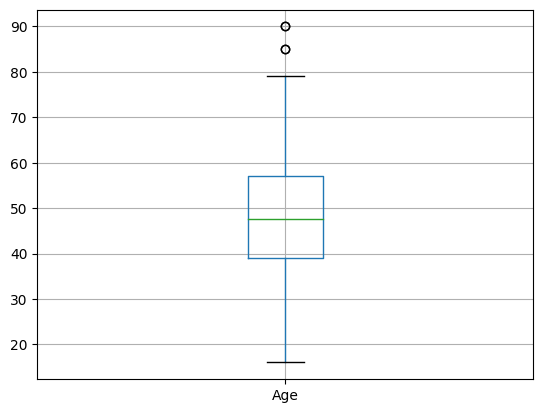

In [8]:
# Verificando outliers
df.boxplot('Age')

In [9]:
#Verificando Quartis para tratamento de outliers
Q1 = np.percentile(df['Age'], 25,
                   method = 'midpoint')

Q3 = np.percentile(df['Age'], 75,
                   method = 'midpoint')
IQR = Q3 - Q1

print("Old Shape:", df.shape)

# Upper bound
upper = np.where(df['Age'] >= (Q3+1.5*IQR))
# Lower bound
lower = np.where(df['Age'] <= (Q1-1.5*IQR))

#Removendo outliers
df.drop(upper[0], inplace = True)
df.drop(lower[0], inplace = True)

print("New Shape:", df.shape)

Old Shape: (520, 17)
New Shape: (516, 17)


<ipython-input-10-54634432ab5f>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sn.heatmap(df.corr(),annot=True, cmap ='coolwarm')


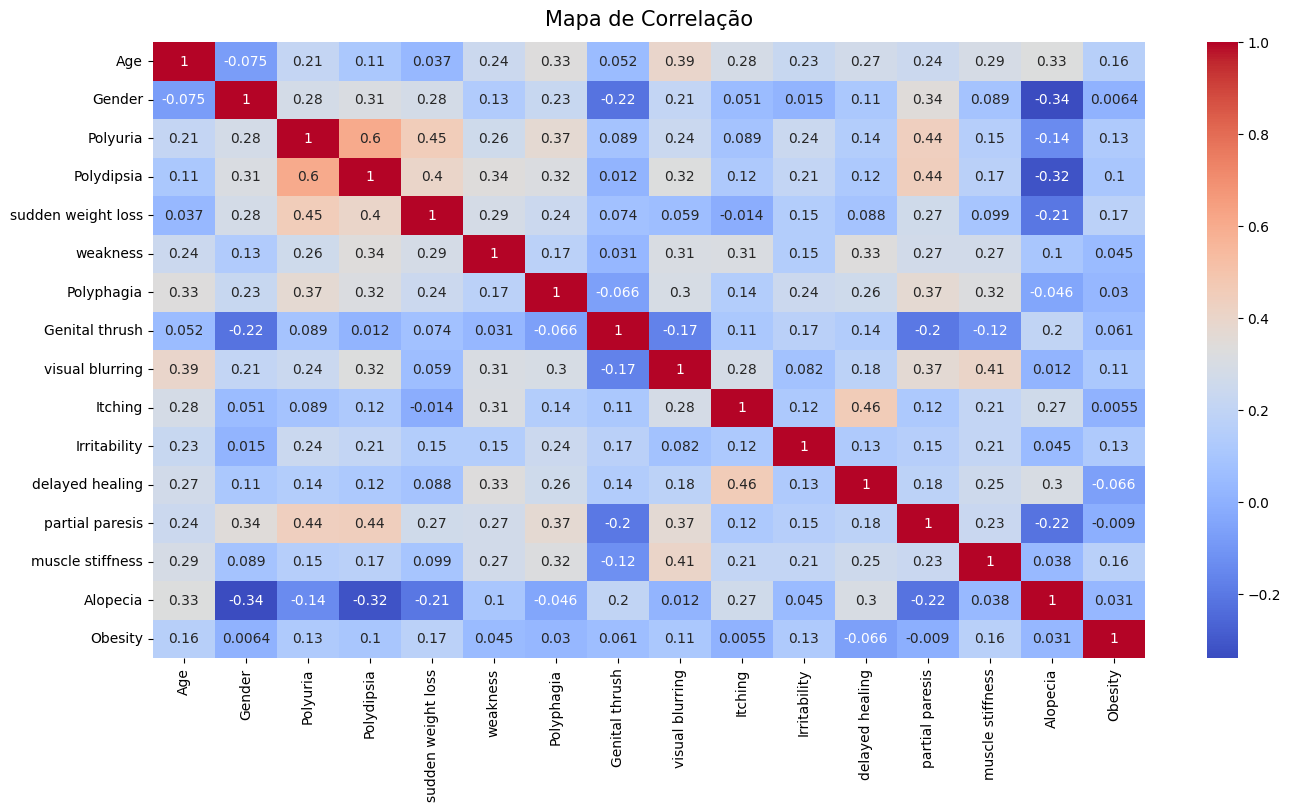

In [10]:
#Matriz de correlação
plt.figure(figsize=(16,8))
sn.heatmap(df.corr(),annot=True, cmap ='coolwarm')
plt.title("Mapa de Correlação",fontsize=15, pad=12)
plt.show()

In [11]:
# Dados de treino: 70% e Dados de teste: 30%.
Y = df['class']
X = df.drop('class', axis=1)
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size = 0.3,random_state=1)
X_train.shape, X_test.shape

((361, 16), (155, 16))

In [12]:
df['class'].value_counts()*0.7

Positive    221.2
Negative    140.0
Name: class, dtype: float64

##**Classificador:**

##🌳**Random Forest**





In [13]:
#n_estimators: número de árvores na floresta do modelo
#criterion: entropia - mede a impureza ou incerteza em um grupo de observações.
#Determina como uma árvore de decisão escolhe dividir os dados.

rf = RandomForestClassifier(n_estimators=20, criterion='entropy')

#RFECV (Recursive feature elimination with cross-validation):
#Eliminação recursiva de recursos com validação cruzada para selecionar recursos.
#step: número de features removidas a cada iteração
#cv: gerador de cross-validation ou iterável
rfecv = RFECV(estimator=rf, step=1, cv=5, scoring='accuracy')

# Ajustando o objeto RFECV aos dados de treinamento
rfecv.fit(X_train, y_train)

# Obtendo os melhores atributos
X_train_selected = rfecv.transform(X_train)
X_test_selected = rfecv.transform(X_test)

# Treinando o classificador Random Forest com os atributos selecionados
rf.fit(X_train_selected, y_train)

# Previsões rótulos do conjunto de teste
y_pred = rf.predict(X_test_selected)

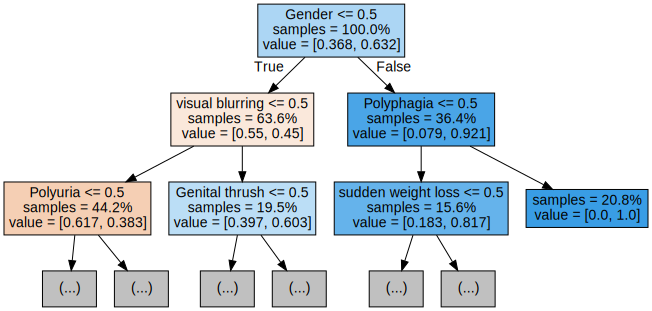

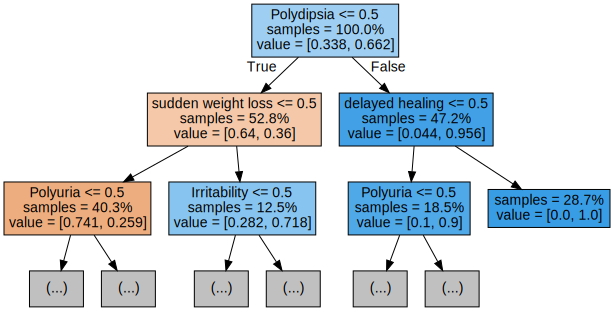

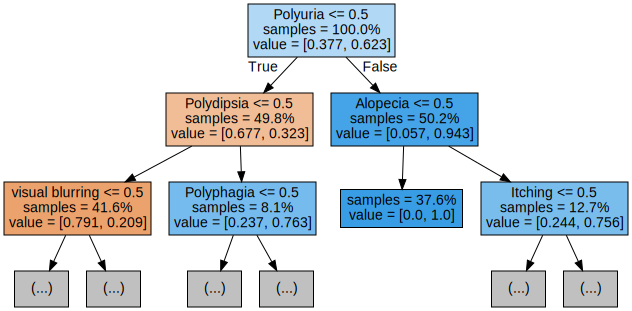

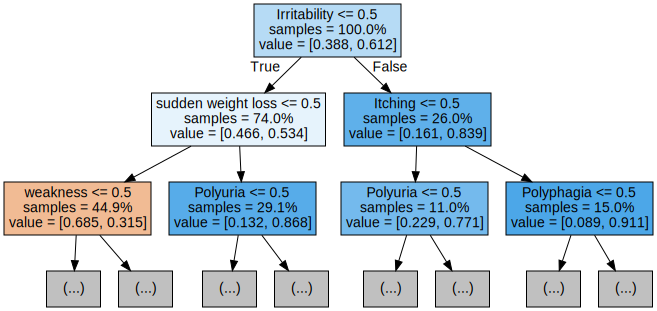

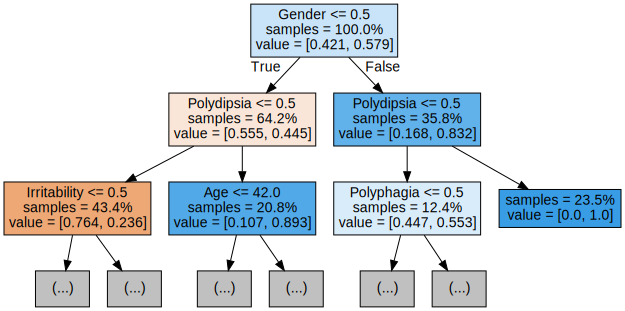

In [14]:
#Gerando as 5 primeiras árvores
#As cores representam a classe majoritária de cada nó:
#Caixa com laranja indica maioria 0 e azul indicando maioria 1.
#Cores ficam mais escuras quanto mais próximo o nó chega de ser totalmente 0 ou 1.

for i in range(5):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,
                               filled=True,
                               max_depth=2,
                               impurity=False,
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

## ✅ **Resultados**



Text(0.5, 1.0, 'Matriz de Confusão')

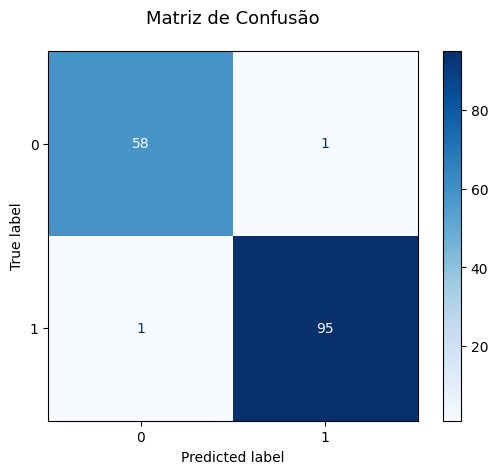

In [15]:
#Matriz de Confusão
rf_cm = confusion_matrix(y_test,y_pred)
disp=ConfusionMatrixDisplay(confusion_matrix=rf_cm)
disp.plot(cmap='Blues')
plt.title('Matriz de Confusão',fontsize=13, pad=20)

*   True Positive --> 58
*   True Negative --> 95
*   False Positive --> 1
*   False Negative --> 1


In [16]:
accuracy = accuracy_score(y_test, y_pred)
rf_cr = classification_report(y_test,y_pred)
print('Accuracy: {:.2f}%'.format(accuracy *100))
print('\n')
print('Classification report')
print(rf_cr)

Accuracy: 98.71%


Classification report
              precision    recall  f1-score   support

    Negative       0.98      0.98      0.98        59
    Positive       0.99      0.99      0.99        96

    accuracy                           0.99       155
   macro avg       0.99      0.99      0.99       155
weighted avg       0.99      0.99      0.99       155

